# EIT Continuous Model Complex-Valued Tests

This work aims to set first tests with EIT implementantion using FENICSx library, aiming to solve the complex valued case, explaining some of the fundamentals in the library implementation. In this context, we will be using the Continuous Model, testing initially with trivial simulated functions and simple meshes, adding more information and complexity as advancing.

More information and explanations about some steps can be seen in the FENICSx tutorial: https://jsdokken.com/dolfinx-tutorial/chapter1/complex_mode.html.

## EIT Continuous Model

Given a domain $\Omega \in \mathbb R^2$, an admitivity $\gamma: \Omega \to \mathbb C$, a potential distribution $u : \Omega \to \mathbb  C$ and a current $g : \partial \Omega \to \mathbb R$ in the border $\partial \Omega$ of $\Omega$, the EIT Continuous Model stablishes the following PDE:

$$
\nabla \cdot ( \gamma \nabla u) = 0, \text{ in } \Omega\\
\gamma \frac{\partial u}{\partial \eta} = g, \text{ in } \partial \Omega
$$

First equation also may be written as $div(\gamma \nabla u) = g$.

This PDE with stablished conditions may also be transformed in a weak variational formulation. Basically, we want to find $u$ such that for any given $v \in H^1_{\Diamond}$, it solves:

$$
\int_{\Omega} \gamma \nabla u \cdot \nabla v dx = \int_{\partial \Omega} g v dS
$$,

where $H^1_{\Diamond} = \{f \in H^1 : \int_{\partial \Omega} f = 0\}$.

## Implementation

In [1]:
import sys
import dolfinx
from mpi4py import MPI #import parallel communicator
import numpy as np
import ufl
print("Python version: ", sys.version)
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")


#Check type of number set in PETSc lib, returns error if not complex
from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

Python version:  3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]
DOLFINx version: 0.6.0 based on GIT commit: 24f86a9ce57df6978070dbee22b3eae8bb77235f of https://github.com/FEniCS/dolfinx/
<class 'numpy.complex128'>


## Tests with square domain



In [34]:
# Create unit square mesh
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

#Define function space
V = dolfinx.fem.FunctionSpace(mesh, ("CG", 1))

#Define functions 
# u_s = dolfinx.fem.Function(V,dtype=np.complex128)
# u_s.interpolate(lambda x: x[0]**2 - 1j*x[1]**2)
# g = dolfinx.fem.Function(V,dtype=np.complex128)
# g.interpolate(lambda x: x[0]**2 - x[1]**2)

x = ufl.SpatialCoordinate(mesh)
g = x[0]**2 - x[1]**2

In [35]:
#Trial and test functions
u = ufl.TrialFunction(V) #function u_h
v = ufl.TestFunction(V)

In [44]:
#gamma
gamma = dolfinx.fem.Constant(mesh, PETSc.ScalarType(1+1j)) #defining constant 1+1j function over mesh

#Left hand side
gradu = ufl.grad(u)
gradv = ufl.grad(v)
dx = ufl.dx
ds = ufl.ds

a = (gamma * ufl.inner(gradu, gradv)) * dx #\int \nabla u * \overline \nabla v dx

#Right hand side
L = ufl.inner(g,v) * ufl.ds

#Obs: inner product is set to consider the conjugate in second term

In [45]:
problem = dolfinx.fem.petsc.LinearProblem(a,L)
us = problem.solve()

In [46]:
## Plotting
import pyvista
pyvista.start_xvfb()
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.create_vtk_mesh(mesh, mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.create_vtk_mesh(V)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.point_data["u_real"] = us.x.array.real
grid.point_data["u_imag"] = us.x.array.imag


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



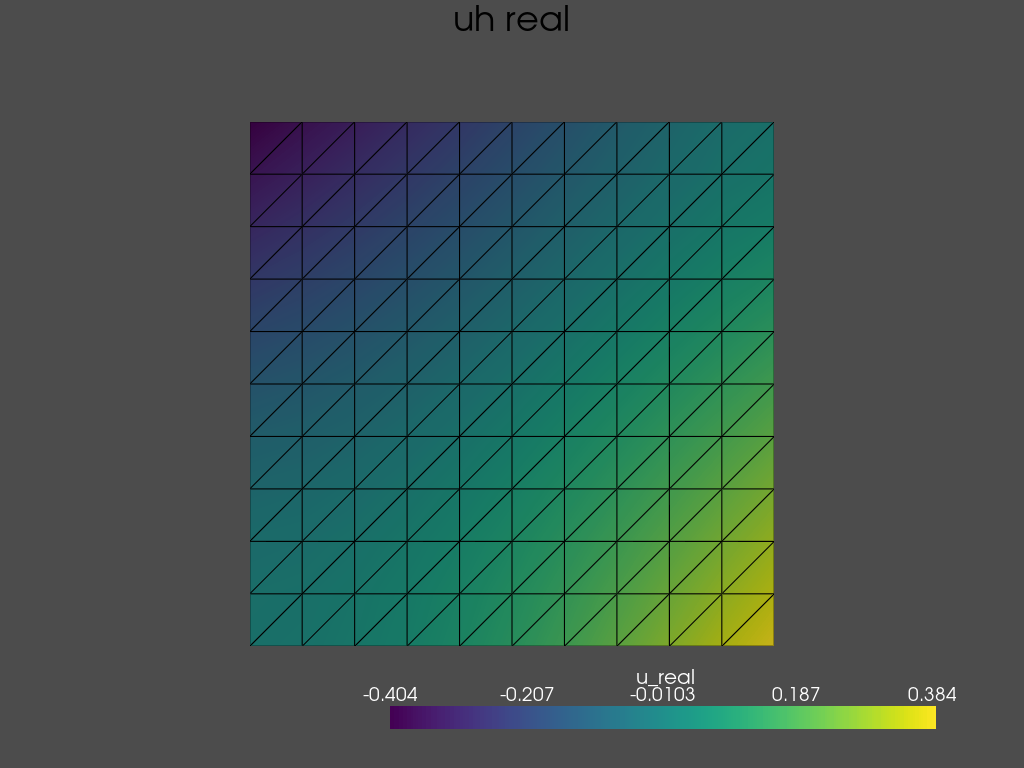

In [47]:
#Plot real
grid.set_active_scalars("u_real")
p_real = pyvista.Plotter()
p_real.add_text("uh real", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid, show_edges=True)
p_real.view_xy()
if not pyvista.OFF_SCREEN:
    p_real.show()

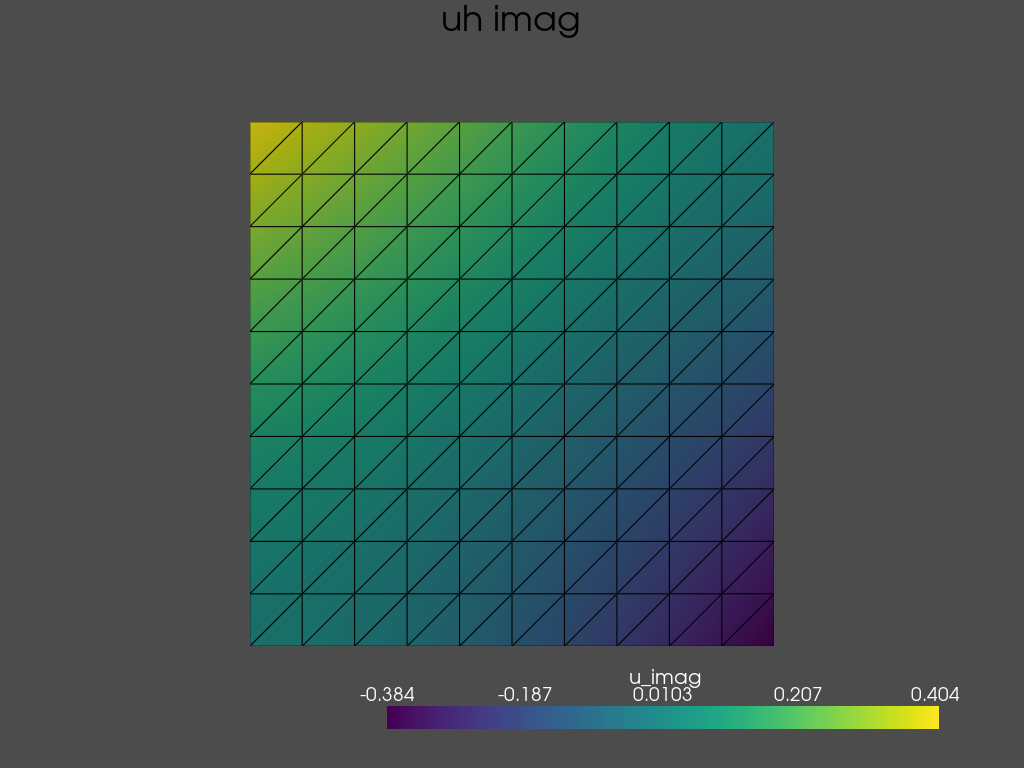

In [48]:
grid.set_active_scalars("u_imag")
p_imag = pyvista.Plotter()
p_imag.add_text("uh imag", position="upper_edge", font_size=14, color="black")
p_imag.add_mesh(grid, show_edges=True)
p_imag.view_xy()
if not pyvista.OFF_SCREEN:
    p_imag.show()
